In [1]:
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import torchvision

from ipywidgets import interact


from datasets import ImageDataset
from models import *

import torch
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

output_path = "/root/autodl-tmp/output/dualGAN"
data_path="/root/autodl-tmp/FLIR_ADAS_v2"
# "20220604_110426"
batch_size = 5
n_cpu = 8

timestamp_1 = '20220610_234847'#高还原网络
timestamp_2 = '20220610_181556'#迁移网络
epoch_1 = 10
epoch_2 = 10

############################################## keep the same as dualgan.py ################################################
# G_AB_0 = Generator(3,3,is_A2B=True)
# G_AB_0.load_state_dict(torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp, epoch_1)))
G_AB_0 = torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp_1, epoch_1))
# G_AB_1 = Generator(3,3,is_A2B=True)
# G_AB_1.load_state_dict(torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp, epoch_2)))
G_AB_1 = torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp_2, epoch_2))

# Configure dataloader
A_transforms = [
    # transforms.Grayscale(),    
    transforms.CenterCrop(size=1024),
    transforms.Resize(size=256),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
B_transforms = [
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop(size=256),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset("%s/images_rgb_train/data" % data_path, "%s/images_thermal_train/data" % data_path,
                A_transforms,B_transforms),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

############################################################################################################################


In [2]:
def interp(alpha,p_G_AB_0,p_G_AB_1):
    net_interp = OrderedDict()

    print('Interpolating with alpha = ', alpha)

    for k, v_G_AB_0 in p_G_AB_0.items():
        v_G_AB_1 = p_G_AB_1[k]
        net_interp[k] = (1 - alpha) * v_G_AB_0 + alpha * v_G_AB_1

    interp_G_AB = Generator(3,3,is_A2B=True)
    interp_G_AB.load_state_dict(net_interp)
    return interp_G_AB

In [3]:
from copy import deepcopy
def show(imgs):
    def inverse_normalize(tensor, mean, std):# 避免normalize之后显示出来的图像偏黑
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    if not isinstance(imgs, list):
        imgs = [imgs]
    fig , axes = plt.subplots(len(imgs),len(imgs[0]), squeeze=False,figsize=(12,12))
    fig.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0, hspace=0)
    for i, img_list in enumerate(imgs):
        for j , img in enumerate(img_list):
            img_ = img.detach()
            img = deepcopy(img_)
            img = torchvision.transforms.functional.to_pil_image(inverse_normalize(img.cpu(),mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
            axes[i, j].imshow(np.asarray(img))
            axes[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [31]:
imgs = next(iter(dataloader))['A']

In [33]:
@interact(alpha=(0,1.0))
def show_interp(alpha):
    inter_net = interp(alpha,G_AB_0,G_AB_1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inter_net = inter_net.to(device)
    gen = inter_net(imgs.to(device))
    show([imgs,gen])
    

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

Interpolating with alpha =  0.0
Interpolating with alpha =  0.2
Interpolating with alpha =  0.4
Interpolating with alpha =  0.6
Interpolating with alpha =  0.8
Interpolating with alpha =  1.0


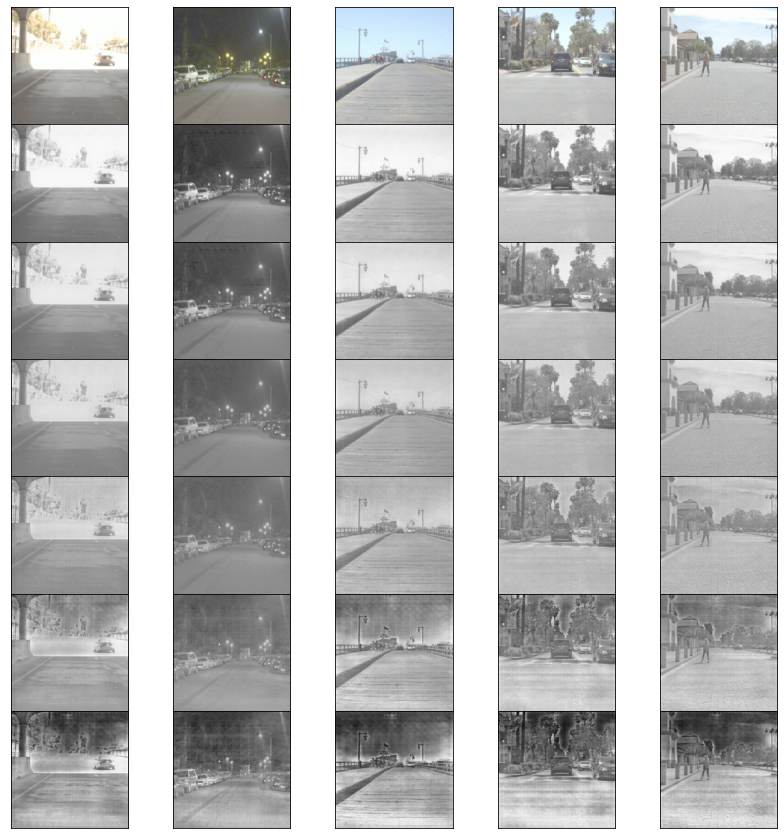

In [27]:
def show_all_interp():
    gens = []
    for alpha in range(0,12,2):
        alpha = alpha/10
        inter_net = interp(alpha,G_AB_0,G_AB_1)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        inter_net = inter_net.to(device)
        gen = inter_net(imgs.to(device))
        gens.append(gen)
    show([imgs]+gens)
show_all_interp()

In [19]:
# show(list(imgs['A'][:2]))
# inter_G_AB = interp(0.4,p_G_AB_0,p_G_AB_1)
# interp_img = inter_G_AB(imgs['A'])
# show(list(interp_img[:2]))

# img_0 = G_AB_0(imgs['A'])
# show(list(img_0[:2]))
# img_1 = G_AB_1(imgs['A'])
# show(list(img_1[:2]))

In [29]:
f=plt.gcf()
f.savefig('res.jpg')

<Figure size 432x288 with 0 Axes>